In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16, MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

2024-08-04 21:13:10.806591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 21:13:10.970885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 21:13:11.082967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 21:13:11.108979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 21:13:11.242787: I tensorflow/core/platform/cpu_feature_guar

In [2]:
warnings.warn("ignore")

/tmp/ipykernel_5765/994036171.py:1: UserWarning: ignore
  warnings.warn("ignore")


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

I0000 00:00:1722816805.606186    5765 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722816805.767015    5765 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722816805.769174    5765 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7*1024)]) 
    except RuntimeError as e:
        print(e)

In [5]:
image_path = 'data/asl_alphabet_train/asl_alphabet_train/'
models_path = 'models/asl_model.keras'
preprocessing_path = 'data/preprocessing/train/'
rgb = False
imageSize = 224

In [6]:
gestures = { chr(i): i - 65 for i in range(65,91)}
# gestures = { chr(i): i - 65 for i in range(65,75)}
gestures['space'] = len(gestures)

In [7]:
gestures.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space'])

In [8]:
def preprocessing_image(gesture, imageSize, rgb):
    if not os.path.exists(f'{preprocessing_path}{gesture}'):
        os.makedirs(f'{preprocessing_path}{gesture}')
    for f in os.listdir(f'{image_path}{gesture}'):
        image = Image.open(f'{image_path}{gesture}/{f}')
        if not rgb:
            image_gray = image.convert("L")
        else:
            image_gray = image.copy()
            
        image_gray.resize((imageSize,imageSize))
        image_gray.save(f'{preprocessing_path}{gesture}/{f}', quality=50, optimize=True)
        image_gray.close()

In [9]:
for gesture in gestures: 
    preprocessing_image(gesture, 224, True)

In [11]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((imageSize, imageSize))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    # if rgb:
    #     pass
    # else:
    #     X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def load_dataset(image_path, gestures, size):
    X_data = []
    y_data = []

    for x in gestures.keys():
        for f in os.listdir(f'{image_path}{x}')[:size]:
            X_data.append(process_image(f'{image_path}{x}/{f}'))
            y_data.append(gestures[x])
    

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [12]:
X, y = load_dataset(image_path=preprocessing_path, gestures=gestures, size=150)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [15]:
model_checkpoint = ModelCheckpoint(filepath=models_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)

In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape = [imageSize, imageSize, 3]))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dense(units=len(gestures), activation='softmax'))



/home/caio/Documents/development/mba/deep_learning/venv/lib64/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1722817073.204220    5765 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722817073.207911    5765 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00

In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=1, 
                    callbacks=[early_stopping, model_checkpoint]
                    )


Epoch 1/5


I0000 00:00:1722817089.949349   14332 service.cc:146] XLA service 0x7ff31c01e100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722817089.949419   14332 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-04 21:18:10.027994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-04 21:18:10.165139: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-04 21:18:17.751610: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=2,k3=0} for conv (f32[32,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0",

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.0335 - loss: 3.6094

2024-08-04 21:19:56.406416: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 36 bytes spill stores, 36 bytes spill loads

2024-08-04 21:20:03.735714: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[10,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,64,112,112]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-04 21

102/102 ━━━━━━━━━━━━━━━━━━━━ 117s 674ms/step - accuracy: 0.0336 - loss: 3.6072 - val_accuracy: 0.0370 - val_loss: 3.3042
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.0696 - loss: 3.2776 - val_accuracy: 0.2420 - val_loss: 2.6118
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.4325 - loss: 1.9217 - val_accuracy: 0.7642 - val_loss: 0.7971
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.8413 - loss: 0.5031 - val_accuracy: 0.8210 - val_loss: 0.6148
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.9227 - loss: 0.2151 - val_accuracy: 0.9247 - val_loss: 0.3810
Restoring model weights from the end of the best epoch: 5.


In [19]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9212 - loss: 0.3608


In [20]:
accuracy

0.924691379070282

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,277,875 (294.79 MB)

 Trainable params: 25,759,291 (98.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,518,584 (196.53 MB)

In [22]:
test_path = "data/test/"

In [24]:
def preprocessing_image_test(test_path, imageSize, rgb):
    for f in os.listdir(f'{test_path}'):
        if ".jpg" not in f:
            continue
        image = Image.open(f'{test_path}{f}')
        if not rgb:
            image_gray = image.convert("L")
        else:
            image_gray = image.copy()
            
        image_gray.resize((imageSize,imageSize))
        image_gray.save(f'{test_path}preprocessing/{f}', quality=50, optimize=True)
        image_gray.close()

In [25]:
preprocessing_image_test(test_path,  224, True)

In [37]:
X_, y_ = load_dataset(image_path=f'{test_path}preprocessing/', gestures={"":0}, size=15)

In [38]:
y_pred = model.predict(X_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [35]:
max(y_pred[0])

0.9979303

In [39]:
for l in y_pred:
    print(list(gestures.keys())[np.argmax(l)])

M
B
P
space
U
N
I
F
O
R
P


In [58]:
gestures

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'space': 26}

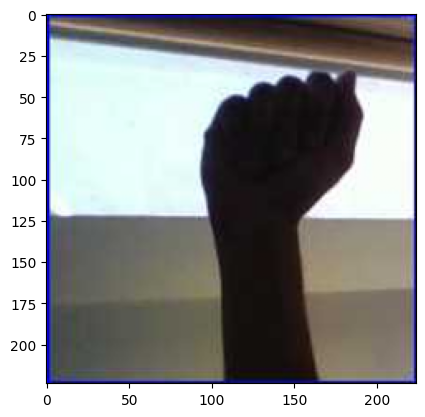

In [32]:
plt.imshow(X_[2])